# WiDS 2018 Datathon

Predictive Analytics for Social Impact

Competition on [Kaggle](https://www.kaggle.com/c/wids2018datathon)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from helpers import format_submission

In [2]:
seed = 37

train = pd.read_csv('data/train.csv', low_memory=False)
test = pd.read_csv('data/test.csv', low_memory=False)

print 'Train Shape: {}'.format(train.shape)
print 'Test Shape: {}'.format(test.shape)

Train Shape: (18255, 1235)
Test Shape: (27285, 1234)


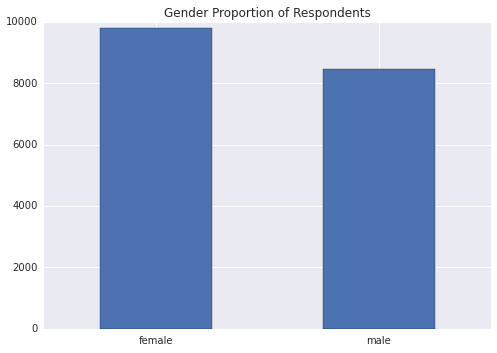

Percentage female: 0.54%
Percentage male: 0.46%
Total respondents: 18255


In [3]:
# Gender proportions survey respondents
train.is_female.value_counts().plot(kind='bar', title='Gender Proportion of Respondents')
plt.xticks(np.arange(0,2), ['female', 'male'], rotation=0)
plt.show()

num_female = len(train[train.is_female==1])
num_male = len(train[train.is_female==0])
total = len(train)

print 'Percentage female: {:.2}%'.format(float(num_female)/total)
print 'Percentage male: {:.2}%'.format(float(num_male)/total)
print 'Total respondents: {}'.format(total)

In [80]:
# Explore DK (99) as a response
no_DKs = []
many_DKs = []
for c in train.columns:
    num_DKs = len(train[train[c]==99])
    percentage = float(num_DKs)/len(train)
    if num_DKs == 0:
        no_DKs.append(num_DKs)
    if percentage >= .8:
        many_DKs.append(c)
        print 'Column Name: {}'.format(c)
        print 'Percentage DK: {:.2}%'.format(percentage)
        print ''
print 'Number of features with no DKs: {}'.format(len(no_DKs))

Column Name: IFI14_4
Percentage DK: 0.89%

Column Name: IFI14_5
Percentage DK: 0.9%

Column Name: IFI14_6
Percentage DK: 0.9%

Column Name: IFI14_7
Percentage DK: 0.84%

Column Name: IFI15_3
Percentage DK: 0.8%

Column Name: IFI15_4
Percentage DK: 0.9%

Column Name: IFI15_5
Percentage DK: 0.9%

Column Name: IFI15_6
Percentage DK: 0.9%

Column Name: IFI15_7
Percentage DK: 0.85%

Number of features with no DKs: 1054


In [7]:
# # Relationship between gender and DK (99) as response
# for c in many_DKs:
#     train.groupby('is_female')[c].value_counts().unstack(1).plot(kind='bar', title=c)
    
#     # Plot formatting
#     plt.xticks(np.arange(0,2), ['male', 'female'], rotation=0)
#     plt.xlabel('')
#     plt.title(c+'\n')
#     plt.legend(title=None, loc=0)
#     plt.show()

In [105]:
# Remove features with many (80%+) DK (99) responses
train.drop(many_DKs, axis=1, inplace=True)
test.drop(many_DKs, axis=1, inplace=True)

In [218]:
# # Visualize relationship between gender and select demographics/survey responses
# features = ['AA3', 'DG3', 'DG3A', 'DG4', 'DG5_4', 'DG6', 'DL0',
#             'DL1', 'DL2', 'DL3', 'DL25_8', 'MT1A', 'MT2', 'MT7A', 'FF1', 'FL4']

# titles = ['Zone', 'Marital status', 'Religion', 'Education level',
#          'Driver\'s License', 'Relation to Household Head', 'Main Income Earner', 'Work/Student Past 12 Mos',
#          'Primary Job', 'Secondary Job', 'Miss family event due to transportation', 'Who Decides on Mobile Phone',
#          'Own Mobile Phone', 'Borrow Phone', 'Bank Account', 'Depend on for Financial Advice']

# for pair in zip(features, titles):
#     colName = pair[0]
#     title = pair[1]
    
#     train.groupby('is_female')[colName].value_counts().unstack(1).plot(kind='bar')
        
#     # Plot formatting
#     plt.xticks(np.arange(0,2), ['male', 'female'], rotation=0)
#     plt.xlabel('')
#     plt.title(title+'\n')
#     plt.legend(title=None, loc=0)
#     plt.show()

In [219]:
# # Downsample to address class imbalance
# train_female = train[train.is_female == 1]
# train_male = train[train.is_female == 0]
# train_female_sample = train_female.sample(n=num_male, random_state=seed)
# train_new = pd.concat([train_male, train_female_sample], axis=0, ignore_index=True).sample(frac=1)

In [220]:
# num_female = len(train_new[train_new.is_female==1])
# num_male = len(train_new[train_new.is_female==0])
# total = len(train_new)

# print 'Percentage female: {:.2}%'.format(float(num_female)/total)
# print 'Percentage male: {:.2}%'.format(float(num_male)/total)
# print 'Total respondents: {}'.format(total)

In [106]:
# Drop unimportant features
#train = train.drop(['FL9B'], axis=1)
#train = train.drop(['FL9B', 'FF3', 'FB20', 'IFI24', 'DG14'], axis=1)
# train = train.drop(['FL9B', 'FF3', 'FB20', 'IFI24', 'DG14', 'GN5', 'DL5',
#                    'DG5', 'DL4', 'DL25', 'DL26', 'MM1', 'MM2', 'MM3', 'MMP1', 'IFI1',
#                    'IFI3', 'FL7', 'FL12', 'FL13', 'FB16', 'FB19A', 'FB22', 'FB27',
#                    'FB29'], axis=1)
train = train.drop(['FL9B', 'FF3', 'FB20', 'IFI24', 'DG14', 'GN5', 'DL5'], axis=1)
#test = test.drop(['FL9B', 'FF3', 'FB20', 'IFI24', 'DG14', 'GN5', 'DL5'], axis=1)

In [107]:
poor_cols_formatted = []
for c in poor_cols:
    c = c.split('_')
    if len(c) == 3:
        c = c[0]+'_'+c[1]
    else:
        c = c[0]
    poor_cols_formatted.append(c)

In [108]:
train = train.drop(poor_cols_formatted, axis=1)

In [4]:
label = train['is_female']
del train['is_female']

del train['train_id']
del test['test_id']

# Remove rows/columns that are missing all data
train = train.dropna(axis=0, how='all')
train = train.dropna(axis=1, how='all')

# Convert to categorical
train_str = train.applymap(str)
train_dum = pd.get_dummies(train_str)

In [110]:
# Remove columns that end in _OTHERS_nan
remove = []
for col in train_dum.columns:
    if col.endswith('_nan'):
        remove.append(col)
train_dum.drop(remove, axis=1, inplace=True)

In [5]:
# Split into train and validation set
X_train, X_test, y_train, y_test = train_test_split(train_dum, label, test_size=0.2, random_state=seed)

#### Feature Selection

In [190]:
sel = VarianceThreshold(threshold=0.01)
X_train_new = sel.fit_transform(X_train)
X_test_new = sel.transform(X_test)

# Logistic Regression with VarianceThreshold
start = time.time()
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(X_train_new, y_train)

preds = clf.predict(X_test_new)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'Logistic Regression with Variance Threshold'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:0.2f} minutes\n'.format(run_time)

# Fit XGBoost Classifier with VarianceThreshold
start = time.time()
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(X_train_new, y_train, eval_metric='auc')

preds = clf.predict(X_test_new)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier with Variance Threshold'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:0.2f} minutes\n'.format(run_time)

Logistic Regression with Variance Threshold
ROC AUC Score: 0.899343348066
Run time: 0.02 minutes

XGBoost Classifier with Variance Threshold
ROC AUC Score: 0.905400092193
Run time: 3.82 minutes



In [191]:
ch2 = SelectKBest(chi2, k=1000)
X_train_new = ch2.fit_transform(X_train, y_train)
X_test_new = ch2.transform(X_test)

# Logistic Regression with SelectKBest
start = time.time()
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(X_train_new, y_train)

preds = clf.predict(X_test_new)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'Logistic Regression with SelectKBest (1000)'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:0.2f} minutes\n'.format(run_time)

# Fit XGBoost Classifier with SelectKBest
start = time.time()
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(X_train_new, y_train, eval_metric='auc')

preds = clf.predict(X_test_new)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier with SelectKBest (1000)'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:0.2f} minutes\n'.format(run_time)

Logistic Regression with SelectKBest (1000)
ROC AUC Score: 0.898382548334
Run time: 0.01 minutes

XGBoost Classifier with SelectKBest (1000)
ROC AUC Score: 0.906242486691
Run time: 1.79 minutes



In [192]:
ch2 = SelectKBest(chi2, k=2000)
X_train_new = ch2.fit_transform(X_train, y_train)
X_test_new = ch2.transform(X_test)

# Fit XGBoost Classifier with SelectKBest 2000
start = time.time()
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(X_train_new, y_train, eval_metric='auc')

preds = clf.predict(X_test_new)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier with SelectKBest (2000)'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:0.2f} minutes\n'.format(run_time)

XGBoost Classifier with SelectKBest (2000)
ROC AUC Score: 0.906395690411
Run time: 3.59 minutes



In [6]:
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
sfm = SelectFromModel(clf, threshold='mean')
X_train_new = sfm.fit_transform(X_train, y_train)
X_test_new = sfm.transform(X_test)

KeyboardInterrupt: 

In [ ]:
# Logistic Regression with SelectFromModel
start = time.time()
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(X_train_new, y_train)

preds = clf.predict(X_test_new)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'Logistic Regression with SelectFromModel (Threshold = mean)'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:0.2f} minutes'.format(run_time)

In [175]:
for k in range(950, 1500, 2):
    # Perform Feature Selection
    ch2 = SelectKBest(chi2, k=k)
    X_train_new = ch2.fit_transform(X_train, y_train)
    X_test_new = ch2.transform(X_test)

    # Logistic Regression with SelectKBest
    start = time.time()
    clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
    clf.fit(X_train_new, y_train)

    preds = clf.predict(X_test_new)
    score = roc_auc_score(y_test, preds)

    end = time.time()
    run_time = float(end - start)/60

    print 'Logistic Regression with SelectKBest, {} Features'.format(k)
    print 'ROC AUC Score: {}'.format(score)
    print 'Run time: {:0.2f} minutes\n'.format(run_time)

Logistic Regression with SelectKBest, 950 Features
ROC AUC Score: 0.899844536638
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 952 Features
ROC AUC Score: 0.899552138977
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 954 Features
ROC AUC Score: 0.898967343655
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 956 Features
ROC AUC Score: 0.899844536638
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 958 Features
ROC AUC Score: 0.900429331959
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 960 Features
ROC AUC Score: 0.900394533474
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 962 Features
ROC AUC Score: 0.900394533474
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 964 Features
ROC AUC Score: 0.900394533474
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 966 Features
ROC AUC Score: 0.899844536638
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 968 Features
ROC 

Logistic Regression with SelectKBest, 1106 Features
ROC AUC Score: 0.898417346819
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1108 Features
ROC AUC Score: 0.898417346819
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1110 Features
ROC AUC Score: 0.898417346819
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1112 Features
ROC AUC Score: 0.898452145304
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1114 Features
ROC AUC Score: 0.89870974448
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1116 Features
ROC AUC Score: 0.898967343655
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1118 Features
ROC AUC Score: 0.898452145304
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1120 Features
ROC AUC Score: 0.898452145304
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1122 Features
ROC AUC Score: 0.898452145304
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1124 Feat

Logistic Regression with SelectKBest, 1262 Features
ROC AUC Score: 0.897609750807
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1264 Features
ROC AUC Score: 0.897902148468
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1266 Features
ROC AUC Score: 0.897609750807
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1268 Features
ROC AUC Score: 0.897902148468
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1270 Features
ROC AUC Score: 0.898744542965
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1272 Features
ROC AUC Score: 0.898486943789
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1274 Features
ROC AUC Score: 0.898486943789
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1276 Features
ROC AUC Score: 0.898486943789
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1278 Features
ROC AUC Score: 0.898452145304
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1280 Fea

Logistic Regression with SelectKBest, 1418 Features
ROC AUC Score: 0.896286956443
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1420 Features
ROC AUC Score: 0.89683695328
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1422 Features
ROC AUC Score: 0.896286956443
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1424 Features
ROC AUC Score: 0.895994558782
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1426 Features
ROC AUC Score: 0.896286956443
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1428 Features
ROC AUC Score: 0.896286956443
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1430 Features
ROC AUC Score: 0.896286956443
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1432 Features
ROC AUC Score: 0.896579354104
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1434 Features
ROC AUC Score: 0.896579354104
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 1436 Feat

In [174]:
for k in range(500, 5000, 50):
    # Perform Feature Selection
    ch2 = SelectKBest(chi2, k=k)
    X_train_new = ch2.fit_transform(X_train, y_train)
    X_test_new = ch2.transform(X_test)

    # Logistic Regression with SelectKBest
    start = time.time()
    clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
    clf.fit(X_train_new, y_train)

    preds = clf.predict(X_test_new)
    score = roc_auc_score(y_test, preds)

    end = time.time()
    run_time = float(end - start)/60

    print 'Logistic Regression with SelectKBest, {} Features'.format(k)
    print 'ROC AUC Score: {}'.format(score)
    print 'Run time: {:0.2f} minutes\n'.format(run_time)

Logistic Regression with SelectKBest, 500 Features
ROC AUC Score: 0.897094552455
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 550 Features
ROC AUC Score: 0.896648951074
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 600 Features
ROC AUC Score: 0.896871751765
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 650 Features
ROC AUC Score: 0.896871751765
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 700 Features
ROC AUC Score: 0.897386950116
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 750 Features
ROC AUC Score: 0.899071739111
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 800 Features
ROC AUC Score: 0.899656534432
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 850 Features
ROC AUC Score: 0.899552138977
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 900 Features
ROC AUC Score: 0.900464130445
Run time: 0.01 minutes

Logistic Regression with SelectKBest, 950 Features
ROC 

Logistic Regression with SelectKBest, 4400 Features
ROC AUC Score: 0.899879335123
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4450 Features
ROC AUC Score: 0.899879335123
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4500 Features
ROC AUC Score: 0.899621735947
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4550 Features
ROC AUC Score: 0.899879335123
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4600 Features
ROC AUC Score: 0.899879335123
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4650 Features
ROC AUC Score: 0.899879335123
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4700 Features
ROC AUC Score: 0.899621735947
Run time: 0.03 minutes

Logistic Regression with SelectKBest, 4750 Features
ROC AUC Score: 0.899621735947
Run time: 0.03 minutes

Logistic Regression with SelectKBest, 4800 Features
ROC AUC Score: 0.899879335123
Run time: 0.02 minutes

Logistic Regression with SelectKBest, 4850 Fea

In [163]:
for n in range(550, 650, 10):
    # Perform PCA
    pca = PCA(n_components=n, whiten=True, svd_solver='auto')
    pca_train = pca.fit_transform(X_train)
    pca_test = pca.transform(X_test)

    # Logistic Regression with PCA
    start = time.time()
    clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
    clf.fit(pca_train, y_train)

    preds = clf.predict(pca_test)
    score = roc_auc_score(y_test, preds)

    end = time.time()
    run_time = float(end - start)/60

    print 'Logistic Regression with PCA, {} Components'.format(n)
    print 'ROC AUC Score: {}'.format(score)
    print 'Run time: {:0.2f} minutes\n'.format(run_time)

#     # Fit XGBoost Classifier with PCA
#     start = time.time()
#     clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
#     clf.fit(pca_train, y_train, eval_metric='auc')

#     preds = clf.predict(pca_test)
#     score = roc_auc_score(y_test, preds)

#     end = time.time()
#     run_time = float(end - start)/60

#     print 'XGBoost Classifier with PCA, {} Components'.format(n)
#     print 'ROC AUC Score: {}'.format(score)
#     print 'Run time: {:0.2f} minutes\n'.format(run_time)

Logistic Regression with PCA, 550 Components
ROC AUC Score: 0.89884893842
Run time: 0.02 minutes

Logistic Regression with PCA, 560 Components
ROC AUC Score: 0.899398935257
Run time: 0.02 minutes

Logistic Regression with PCA, 570 Components
ROC AUC Score: 0.898055352188
Run time: 0.02 minutes

Logistic Regression with PCA, 580 Components
ROC AUC Score: 0.898452145304
Run time: 0.02 minutes

Logistic Regression with PCA, 590 Components
ROC AUC Score: 0.89870974448
Run time: 0.02 minutes

Logistic Regression with PCA, 600 Components
ROC AUC Score: 0.899600947242
Run time: 0.02 minutes

Logistic Regression with PCA, 610 Components
ROC AUC Score: 0.900874933341
Run time: 0.02 minutes

Logistic Regression with PCA, 620 Components
ROC AUC Score: 0.896955358515
Run time: 0.02 minutes

Logistic Regression with PCA, 630 Components
ROC AUC Score: 0.896217359473
Run time: 0.03 minutes

Logistic Regression with PCA, 640 Components
ROC AUC Score: 0.898452145304
Run time: 0.03 minutes



In [161]:
# PCA, 600 Components
pca = PCA(n_components=600, whiten=True, svd_solver='auto')
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Logistic Regression with PCA
start = time.time()
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(pca_train, y_train)

preds = clf.predict(pca_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'Logistic Regression with PCA, 600 Components'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:2} minutes\n'.format(run_time)

# Fit XGBoost Classifier with PCA
start = time.time()
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(pca_train, y_train, eval_metric='auc')

preds = clf.predict(pca_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier with PCA, 600 Components'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {} minutes'.format(run_time)

Logistic Regression with PCA, 600 Components
ROC AUC Score: 0.898417346819
Run time: 0.0224494695663 minutes

XGBoost Classifier with PCA, 600 Components
ROC AUC Score: 0.858921970046
Run time: 2.51972901821 minutes


In [159]:
# PCA, 500 Components
pca = PCA(n_components=500, whiten=True, svd_solver='auto')
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Logistic Regression
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(pca_train, y_train)

preds = clf.predict(pca_test)
score = roc_auc_score(y_test, preds)

print 'Logistic Regression'
print 'ROC AUC Score: {}'.format(score)

Logistic Regression
ROC AUC Score: 0.896662960854


In [157]:
# PCA, 400 Components
pca = PCA(n_components=400, whiten=True, svd_solver='auto')
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Logistic Regression
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(pca_train, y_train)

preds = clf.predict(pca_test)
score = roc_auc_score(y_test, preds)

print 'Logistic Regression'
print 'ROC AUC Score: {}'.format(score)

Logistic Regression
ROC AUC Score: 0.894588157669


In [156]:
# PCA, 300 Components
pca = PCA(n_components=300, whiten=True, svd_solver='auto')
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Logistic Regression
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(pca_train, y_train)

preds = clf.predict(pca_test)
score = roc_auc_score(y_test, preds)

print 'Logistic Regression'
print 'ROC AUC Score: {}'.format(score)

Logistic Regression
ROC AUC Score: 0.888210996321


In [155]:
# PCA 200 components
pca = PCA(n_components=200, whiten=True, svd_solver='auto')
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Logistic Regression
clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear')
clf.fit(pca_train, y_train)

preds = clf.predict(pca_test)
score = roc_auc_score(y_test, preds)

print 'Logistic Regression'
print 'ROC AUC Score: {}'.format(score)

Logistic Regression
ROC AUC Score: 0.881346656182


In [126]:
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print 'True positives: {}'.format(tp)
print 'False positives: {}'.format(fp)
print 'True negatives: {}'.format(tn)
print 'False negatives: {}'.format(fn)

True positives: 1733
False positives: 138
True negatives: 1572
False negatives: 208


* True positive: predicting female (1) and is female
* False positive: predicting female (1) and is male (0)
* True negative: predicting male (0) and is male
* False negative: predicting male (0) and is female (1)

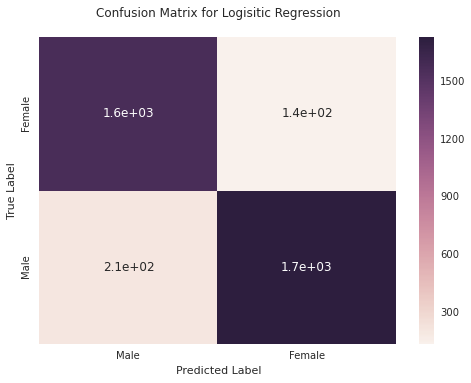

In [139]:
classes = ['Male', 'Female']
sns.heatmap(confusion_matrix(y_test, preds, labels=[0,1]), annot=True)
plt.title('Confusion Matrix for Logisitic Regression\n')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = [0.5, 1.5]
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.show()

In [114]:
# Compare y_test & preds
d = {'True': y_test, 'Predicted': preds}
df_compare = pd.DataFrame(d)
df_compare = df_compare.join(X_test)
df_misclassified = df_compare[df_compare.Predicted != df_compare.True]
df_sum = pd.DataFrame(df_misclassified.sum(axis=0))
df_sum.reset_index(inplace=True)
df_sum.columns = ['Column', 'Sum']
df_sum = df_sum[df_sum.Sum > 250]
poor_cols = df_sum.Column.unique()

In [253]:
# Tune Logistic Regression
start = time.time()

parameters = {'C': np.arange(0.1, 1.1, 0.1), 'fit_intercept': [True, False]}
logreg = LogisticRegression(penalty='l1', solver='liblinear')
clf = GridSearchCV(logreg, parameters, scoring='roc_auc', refit=True)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'Logistic Regression Tuned with GridSearchCV'
print 'Best parameters: {}'.format(clf.best_params_)
print 'Best GridSearchCV ROC AUC score: {}'.format(clf.best_score_)
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {} minutes'.format(run_time)

Logistic Regression Tuned with GridSearchCV
Best parameters: {'C': 0.20000000000000001, 'fit_intercept': False}
Best GridSearchCV ROC AUC score: 0.965016127121
ROC AUC Score: 0.900686931135
Run time: 4.83342744907 minutes


In [121]:
# Fit XGBoost Classifier
start = time.time()
clf = XGBClassifier(max_depth=7, n_estimators=100, random_state=seed)
clf.fit(X_train, y_train, eval_metric='auc')

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier'
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {:2} minutes'.format(run_time)

XGBoost Classifier
ROC AUC Score: 0.906068494265
Run time: 13.7704498013 minutes


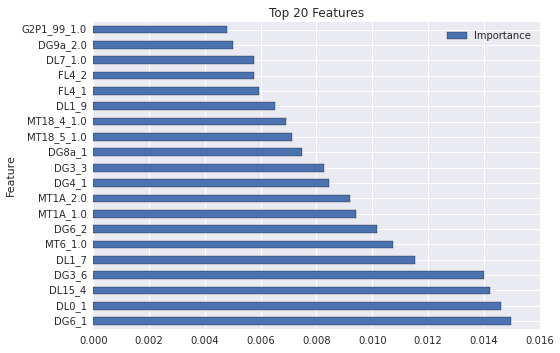

In [123]:
# Create DataFrame of feature importances
importances = clf.feature_importances_
features = X_train.columns.values
d = {'Feature': features, 'Importance': importances}
df_importance = pd.DataFrame(d).set_index('Feature').sort_values(by=['Importance'], ascending=False)

# Visualize Top 20 Important Features
df_importance.head(20).plot(kind='barh', title='Top 20 Features')
plt.show()

In [124]:
df_importance = df_importance.reset_index()

In [125]:
data_dict = pd.read_csv('data/WiDS data dictionary/Codebook-Table 1.csv')
data_dict = data_dict[['Column Name', 'Question', 'Values']]

name = [pair[0] for pair in df_importance.Feature.str.split('_')]
value = [pair[1] for pair in df_importance.Feature.str.split('_')]

df_importance['Name'] = name
df_importance['Value'] = value

df_merged = df_importance.merge(data_dict, how='inner', left_on='Name', right_on='Column Name')
df_merged = df_merged.sort_values(by=['Importance'], ascending=False)
df_merged = df_merged[['Question', 'Values', 'Value', 'Importance']]
df_merged['Values'] = df_merged.Values.str.lstrip('\n').str.split('\n')
df_merged_top20 = df_merged.head(20)
df_merged_bottom20 = df_merged.tail(20)

value_descrip = []
for i, v in enumerate(df_merged_top20.Value.values):
    try:
        v = str(int(float(v)))
        vals = df_merged_top20.Values.values[i]
        vals = [val.split('=') for val in vals]
        for pair in vals:
            if v == pair[0]:
                value_descrip.append(pair[1])
    except ValueError:
        value_descrip.append('nan')

df_merged_top20['Answer'] = value_descrip
df_merged_top20 = df_merged_top20[['Question', 'Answer', 'Importance']]

print 'Top 20 Most Important Features'
print '---------------------------------'
for i in range(len(df_merged_top20)):
    print 'Feature: {}'.format(df_merged_top20.Question.values[i])
    print 'Value: {}'.format(df_merged_top20.Answer.values[i])
    print 'Importance: {}'.format(df_merged_top20.Importance.values[i])
    print ''
    
value_descrip = []
for i, v in enumerate(df_merged_bottom20.Value.values):
    try:
        v = str(int(float(v)))
        vals = df_merged_bottom20.Values.values[i]
        vals = [val.split('=') for val in vals]
        for pair in vals:
            if v == pair[0]:
                value_descrip.append(pair[1])
    except ValueError:
        value_descrip.append('nan')
        
df_merged_bottom20['Answer'] = value_descrip
df_merged_bottom20 = df_merged_bottom20[['Question', 'Answer', 'Importance']]

print '\nTop 20 Least Important Features'
print '-------------------------------'
for i in range(len(df_merged_bottom20)):
    print 'Feature: {}'.format(df_merged_bottom20.Question.values[i])
    print 'Value: {}'.format(df_merged_bottom20.Answer.values[i])
    print 'Importance: {}'.format(df_merged_bottom20.Importance.values[i])
    print ''

Top 20 Most Important Features
---------------------------------
Feature: DG6.How are you related to the household head? 
Value: Myself
Importance: 0.0149855911732

Feature: DL0. Who is the main income earner in your household?
Value: Myself
Importance: 0.014601345174

Feature: DL15.What is the highest grade that the female head/spouse completed? 
Value: No female head/spouse
Importance: 0.0142170991749

Feature: DG3. What is your marital status?
Value: Widow/widower
Importance: 0.0140249757096

Feature: DL1. In the past 12 months, were you mainly...?
Value: Housewife or stay-at-home husband doing household chores
Importance: 0.0115273771808

Feature: MT6.How did you obtain your phone?
Value: I bought it myself
Importance: 0.0107588861138

Feature: DG6.How are you related to the household head? 
Value: Spouse
Importance: 0.0101825166494

Feature: MT1A.Who decides on who should have a phone in your household?
Value: Myself
Importance: 0.00941402465105

Feature: MT1A.Who decides on who s

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# Tune max_depth (1-10) for XGBoost Classifier
start = time.time()

parameters = {'max_depth': range(1, 11, 2)}
xgb = XGBClassifier()
clf = GridSearchCV(xgb, parameters, scoring='roc_auc', refit=True)
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
score = roc_auc_score(y_test, preds)

end = time.time()
run_time = float(end - start)/60

print 'XGBoost Classifier Tuned with GridSearchCV'
print 'Best parameters: {}'.format(clf.best_params_)
print 'Best GridSearchCV ROC AUC score: {}'.format(clf.best_score_)
print 'ROC AUC Score: {}'.format(score)
print 'Run time: {} minutes'.format(run_time)

XGBoost Classifier Tuned with GridSearchCV
Best parameters: {'max_depth': 9}
Best GridSearchCV ROC AUC score: 0.967348403151
ROC AUC Score: 0.910861419157
Run time: 141.508476766 minutes


In [260]:
# Format test set
test_str = test.applymap(str)
total = pd.concat([train_str, test_str], ignore_index=True)
total_dummies = pd.get_dummies(total)
train_dummies = total_dummies.head(len(train))
test_dummies = total_dummies.tail(len(test))

# # Export modified train and test sets to CSV to use with Keras
# train_dummies.to_csv('data/x_train.csv', index=False)
# pd.DataFrame(label).to_csv('data/y_train.csv', index=False)
# test_dummies.to_csv('data/x_test.csv', index=False)

In [262]:
# Update submission number 
sub_number = 12

# Fit best model to full train set
start = time.time()
print 'Fitting model...\n'

clf = LogisticRegression(C=0.2, penalty='l1', solver='liblinear', random_state=seed)
clf.fit(train_dummies, label)
#clf.fit(train_dummies, label, eval_metric='auc')

# Make predictions
print 'Making predictions...\n'
preds = clf.predict_proba(test_dummies)

# Format submission 
print 'Formatting submission...\n'
df = format_submission(preds, len(test_dummies))
df.to_csv('submissions/submission{}.csv'.format(sub_number), index=False)

print 'Program complete!'

end = time.time()
run_time = float(end - start)/60
print 'Run time: {:0.2f} minutes\n'.format(run_time)

Fitting model...

Making predictions...

Formatting submission...

Program complete!
Run time: 0.18 minutes



In [8]:
# Cross-validation on full training set

# Update submission number 
start = time.time()
sub_number = 10

# GridSearchCV
print 'Tuning model...\n'
parameters = {'max_depth': range(1, 11, 2), 'n_estimators': range(50,300,50)}
xgb = XGBClassifier()
clf = GridSearchCV(xgb, parameters, scoring='roc_auc', refit=True)
clf.fit(train_dummies, label)

# Make predictions
print 'Making predictions...\n'
preds = clf.predict_proba(test_dummies)

# Format submission 
print 'Formatting submission...\n'
df = format_submission(preds, len(test_dummies))
df.to_csv('submissions/submission{}.csv'.format(sub_number), index=False)

end = time.time()
run_time = float(end - start)/60

print 'Program complete!\n'
print 'XGBoost Classifier Tuned with GridSearchCV'
print 'Best parameters: {}'.format(clf.best_params_)
print 'Best GridSearchCV ROC AUC score: {}'.format(clf.best_score_)
print 'Run time: {:0.2f} minutes'.format(run_time)

Tuning model...

Making predictions...


Formatting submission...

Program complete!

XGBoost Classifier Tuned with GridSearchCV
Best parameters: {'n_estimators': 250, 'max_depth': 9}
Best GridSearchCV ROC AUC score: 0.969377013799
Run time: 687.11 minutes
